# Setup

## Imports

In [1]:
import numpy as np

##

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

##

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

##

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

2026-02-18 12:10:51.411932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Config

In [2]:
gpus = tf.config.list_physical_devices("GPU")

for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {gpu}")
    except Exception as e:
        print(e)


Enabled memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Data Preprocessing

## Loading Data

In [3]:
cifar10 = tf.keras.datasets.cifar10.load_data()


In [4]:
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

## Train-Test-Valid Split

In [5]:
(X_train_val,y_train_val), (X_test,y_test) = cifar10

In [6]:
X_train_val = X_train_val.astype("float32") / 255 # as they are 8 bit integer  images
X_test = X_test.astype("float32") / 255 

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.1)

In [8]:
type(X_train)

numpy.ndarray

## Plotting Images Samples

In [9]:
y_train[7777]

array([9], dtype=uint8)

In [10]:
y_train[7777][0]   ## returns the int value not a 0 dimension array

9

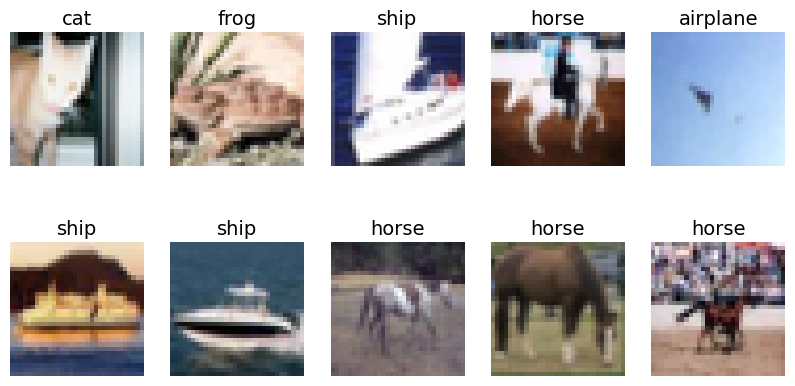

In [11]:
plt.figure(figsize=(10, 5))

for i in range(10):
    k = np.random.choice(len(X_train))
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[k])
    plt.title(class_names[y_train[k][0]])   ## As previously shown
    plt.axis("off")
plt.show()


About to encode y, doing this before the plot makes everything incredibly messy

In [12]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_valid = to_categorical(y_valid, num_classes=10)

you dont need to encode the integer values if you use sparse_categorical_crossentropy instead of categorical_crossentropy.

In [13]:
# X_train = np.expand_dims(X_train, axis=-1)
# X_valid = np.expand_dims(X_valid, axis=-1)
# X_test = np.expand_dims(X_test, axis=-1)

## not necessary as tensors already have the correct number of dimensions for

##  Building an Image Augmentor

In [14]:
idg = ImageDataGenerator(
    # rotation_range=5,        # random rotation up to 15 degrees
    # width_shift_range=0.05,    # horizontal shift
    # height_shift_range=0.05,   # vertical shift
    # horizontal_flip=True,     # randomly flip images
    # zoom_range=0.1,           # zoom in/out
    # fill_mode="nearest",       # fill missing pixels
)

idg.fit(X_train)

image_augmentor = idg.flow(
    X_train,
    y_train,
    batch_size=64
)

# Model 1

## Architecture

In [15]:
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),                            # pooling layer
    tf.keras.layers.Flatten(),                              # bridge to the dense layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

I0000 00:00:1771416655.834363  229881 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10998 MB memory:  -> device: 0, name: AMD Radeon RX 6750 XT, pci bus id: 0000:2d:00.0


In [16]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        81,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,826 (323.54 KB)

 Trainable params: 82,826 (323.54 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling

In [17]:
model_1_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [18]:
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=model_1_optimizer,
    metrics=["accuracy"]
    )

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,                 # metric to monitor             # metric to monitor
    patience=3,                     # stop if no improvement after 3 epochs
    restore_best_weights=True
)

## Fitting

In [20]:
model_1_history = model_1.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping])

Epoch 1/100


2026-02-18 12:10:57.688051: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f121c00b860 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
2026-02-18 12:10:57.688064: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): AMD Radeon RX 6750 XT, AMDGPU ISA version: gfx1030
2026-02-18 12:10:57.702090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  31/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1256 - loss: 3.0811

I0000 00:00:1771416659.530244  230053 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3834 - loss: 1.7972

2026-02-18 12:11:04.694830: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3836 - loss: 1.7964

2026-02-18 12:11:08.894524: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.4655 - loss: 1.5310 - val_accuracy: 0.5604 - val_loss: 1.3058
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5634 - loss: 1.2531 - val_accuracy: 0.5860 - val_loss: 1.2139
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5919 - loss: 1.1763 - val_accuracy: 0.5990 - val_loss: 1.1874
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6113 - loss: 1.1246 - val_accuracy: 0.6214 - val_loss: 1.1253
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6221 - loss: 1.0932 - val_accuracy: 0.6276 - val_loss: 1.1022
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6342 - loss: 1.0691 - val_accuracy: 0.6222 - val_loss: 1.1247
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6373 - loss: 1.0494 - val_accuracy: 0.6332 - val_loss: 1.0938
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6399 - loss: 1.0336 - val

## Evaluating Model

In [21]:
model_1_accuracy = model_1_history.history["accuracy"]
model_1_accuracy_val = model_1_history.history["val_accuracy"]
model_1_loss = model_1_history.history["loss"]
model_1_loss_val = model_1_history.history["val_loss"]

model_1_epochs = range(1,len(model_1_accuracy)+1)


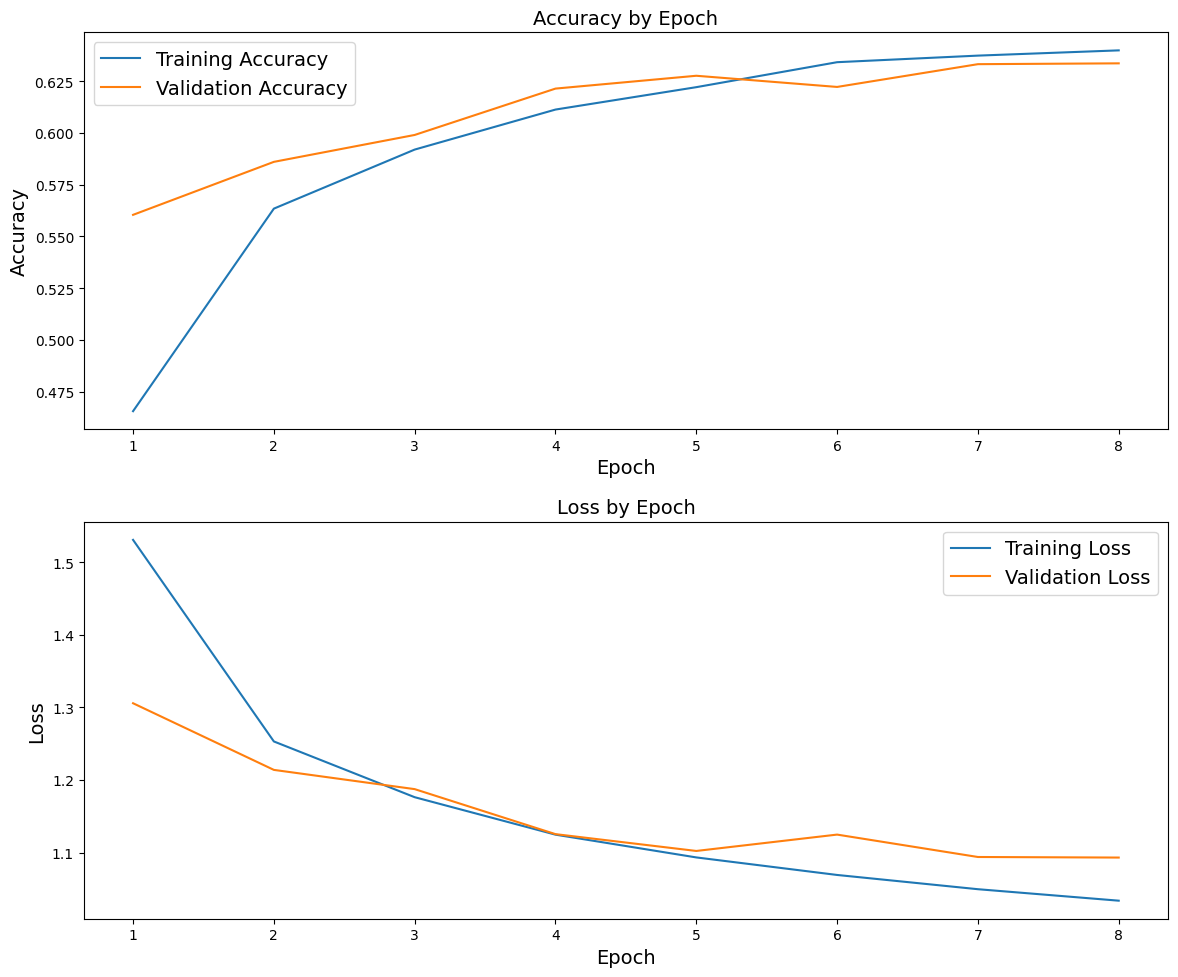

In [22]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(model_1_epochs, model_1_accuracy, label="Training Accuracy")
plt.plot(model_1_epochs, model_1_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(model_1_epochs, model_1_loss, label="Training Loss")
plt.plot(model_1_epochs, model_1_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()



In [23]:
y_pred_probs = model_1.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_test_model_1 = y_test.argmax(axis=1)              ## to make sure y pred and y test are the same shape

acc = accuracy_score(y_test_model_1, y_pred)
prec = precision_score(y_test_model_1, y_pred, average='weighted')
rec = recall_score(y_test_model_1, y_pred, average='weighted')
f1 = f1_score(y_test_model_1, y_pred, average='weighted')

print(f"model_1 Accuracy: {acc:.4f}")
print(f"model_1 Precision: {prec:.4f}")
print(f"model_1 Recall: {rec:.4f}")
print(f"model_1 F1 Score: {f1:.4f}")

report = classification_report(y_test_model_1, y_pred, target_names=class_names)
print(report)

283/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2026-02-18 12:11:50.421583: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
model_1 Accuracy: 0.6311
model_1 Precision: 0.6335
model_1 Recall: 0.6311
model_1 F1 Score: 0.6286
              precision    recall  f1-score   support

    airplane       0.66      0.68      0.67      1000
  automobile       0.78      0.73      0.75      1000
        bird       0.52      0.45      0.48      1000
         cat       0.44      0.56      0.49      1000
        deer       0.61      0.48      0.54      1000
         dog       0.59      0.44      0.51      1000
        frog       0.67      0.77      0.72      1000
       horse       0.69      0.69      0.69      1000
        ship       0.68      0.77      0.72      1000
       truck       0.69      0.73      0.71      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



# Model 2

## Architecture

In [24]:
model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(32,32,3)),
        tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                           # pooling layer

    tf.keras.layers.Conv2D(
        64,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(
        64,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                            # pooling layer

    tf.keras.layers.Conv2D(
        128,
        kernel_size=3,
        padding="valid",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                            # pooling layer

    tf.keras.layers.Flatten(),                              # bridge to the dense layer

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [25]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,298 (1.10 MB)

 Trainable params: 288,298 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling

In [26]:
model_2_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [27]:
model_2.compile(
    loss="categorical_crossentropy",
    optimizer= model_2_optimizer,
    metrics=["accuracy"]
    )

In [28]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,                 # metric to monitor             # metric to monitor
    patience=3,                     # stop if no improvement after 3 epochs
    restore_best_weights=True
)

## Fitting

In [29]:
model_2_history = model_2.fit(
    image_augmentor,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
218/704 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2159 - loss: 2.1736

2026-02-18 12:11:59.281712: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


700/704 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3154 - loss: 1.8715

2026-02-18 12:12:08.789123: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.4143 - loss: 1.5986 - val_accuracy: 0.5706 - val_loss: 1.1985
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6017 - loss: 1.1252 - val_accuracy: 0.6730 - val_loss: 0.9461
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6798 - loss: 0.9129 - val_accuracy: 0.7010 - val_loss: 0.8599
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7234 - loss: 0.7882 - val_accuracy: 0.7424 - val_loss: 0.7442
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7534 - loss: 0.7013 - val_accuracy: 0.7514 - val_loss: 0.7100
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7759 - loss: 0.6384 - val_accuracy: 0.7618 - val_loss: 0.6984
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7982 - loss: 0.5741 - val_accuracy: 0.7712 - val_loss: 0.6632
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8144 - loss: 0.5270 - val_accurac

## Evaluating Model

In [30]:
model_2_accuracy = model_2_history.history["accuracy"]
model_2_accuracy_val = model_2_history.history["val_accuracy"]
model_2_loss = model_2_history.history["loss"]
model_2_loss_val = model_2_history.history["val_loss"]

model_2_epochs = range(1,len(model_2_accuracy)+1)

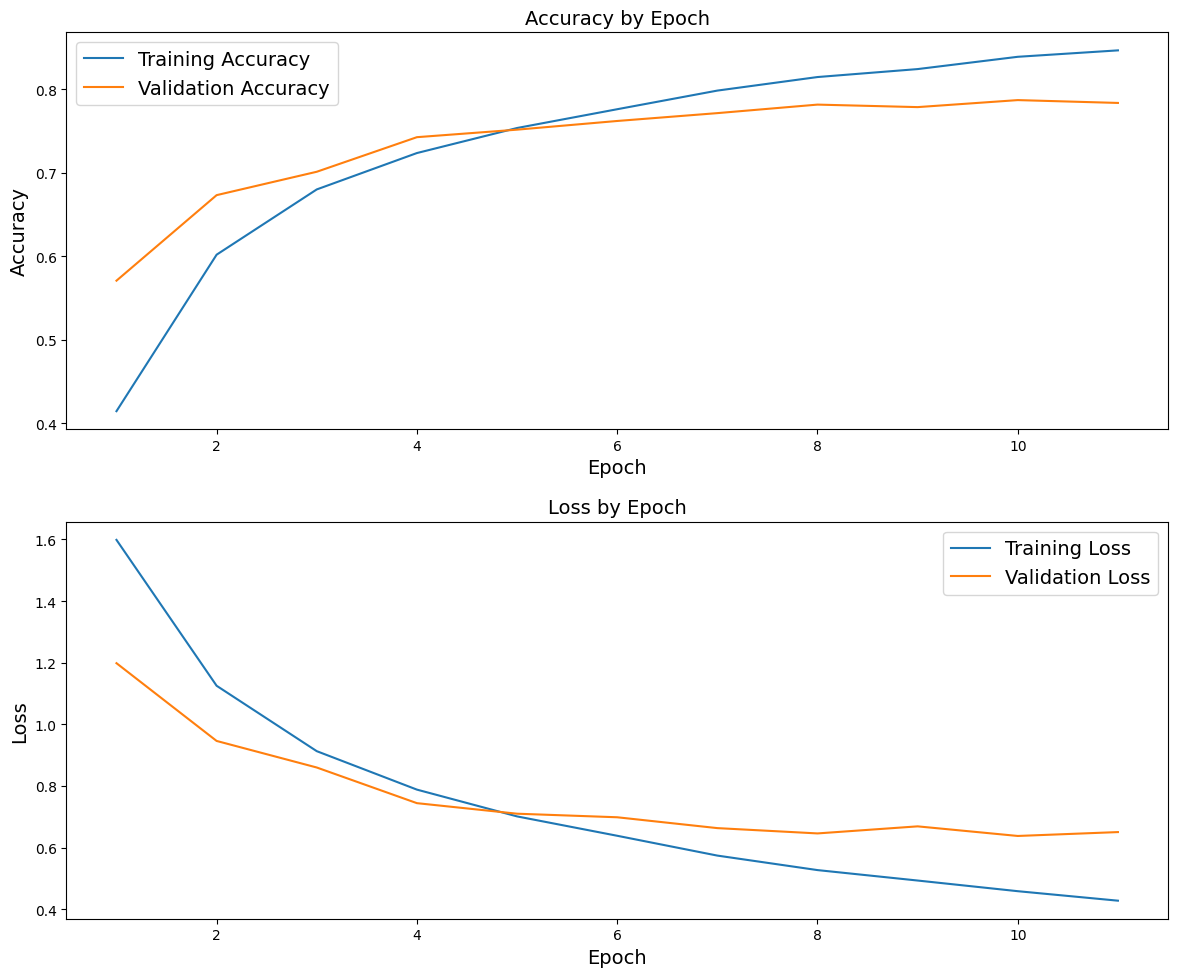

In [31]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(model_2_epochs, model_2_accuracy, label="Training Accuracy")
plt.plot(model_2_epochs, model_2_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(model_2_epochs, model_2_loss, label="Training Loss")
plt.plot(model_2_epochs, model_2_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
y_pred_probs = model_2.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_test_model_2 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_model_2, y_pred)
prec = precision_score(y_test_model_2, y_pred, average='weighted')
rec = recall_score(y_test_model_2, y_pred, average='weighted')
f1 = f1_score(y_test_model_2, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_model_2, y_pred, target_names=class_names)
print(f"\n{report}")

307/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2026-02-18 12:13:27.238952: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
model_2 Accuracy: 0.7751
model_2 Precision: 0.7729
model_2 Recall: 0.7751
model_2 F1 Score: 0.7729

              precision    recall  f1-score   support

    airplane       0.81      0.77      0.79      1000
  automobile       0.85      0.90      0.88      1000
        bird       0.67      0.69      0.68      1000
         cat       0.66      0.56      0.60      1000
        deer       0.74      0.74      0.74      1000
         dog       0.71      0.67      0.69      1000
        frog       0.79      0.86      0.82      1000
       horse       0.83      0.83      0.83      1000
        ship       0.87      0.85      0.86      1000
       truck       0.79      0.89      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.77      0.78      0.77     10000
weighted avg       0.77      0.78      0.77     10000



# Scaling for transfer models

## *Mobile net has a stride problem, for images this small we need to reduce its stride but doing so essentiall requires a rewrite.*

updating image augmentor to rescale images to 64,64,3

In [33]:
X_train_scaled_64 = tf.image.resize(X_train, (64, 64))
X_valid_scaled_64 = tf.image.resize(X_valid, (64, 64))
X_test_scaled_64  = tf.image.resize(X_test, (64, 64))


In [34]:
image_augmentor_scaled_64 = idg.flow(
    X_train_scaled_64,
    y_train,
    batch_size=32
)

2026-02-18 12:13:29.692737: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2211840000 exceeds 10% of free system memory.


# Transfer Learning Mobile Net v2  - Attempt 1  - imageset weights

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [35]:
base_model_1 = MobileNetV2(
    input_shape=(64, 64, 3),    # lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "None",            # has a meltdown if this is set to anything other than "None"
    weights="imagenet"
    )
base_model_1.trainable = False  # Freeze base so mobilenet v2 isn't being trained

/tmp/ipykernel_229881/3331765581.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_1 = MobileNetV2(


In [36]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [37]:
transfer_model_1 = models.Sequential([
    base_model_1,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [38]:
transfer_model_1_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

transfer_model_1.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_1_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,             # metric to monitor
    patience=3,                     # stop if no improvement after 3 epochs
    restore_best_weights=True
)

In [39]:
transfer_model_1_history = transfer_model_1.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.3936 - loss: 1.7384 - val_accuracy: 0.5792 - val_loss: 1.2470
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5434 - loss: 1.3185 - val_accuracy: 0.6154 - val_loss: 1.1215
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5856 - loss: 1.1914 - val_accuracy: 0.6378 - val_loss: 1.0675
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6113 - loss: 1.1212 - val_accuracy: 0.6492 - val_loss: 1.0302
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6272 - loss: 1.0728 - val_accuracy: 0.6510 - val_loss: 1.0113
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6436 - loss: 1.0298 - val_accuracy: 0.6578 - val_loss: 0.9947
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6550 - loss: 0.9991 - val_accuracy: 0.6578 - val_loss: 0.9913
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 

## Evaluating Model

In [40]:
transfer_model_1_accuracy = transfer_model_1_history.history["accuracy"]
transfer_model_1_accuracy_val = transfer_model_1_history.history["val_accuracy"]
transfer_model_1_loss = transfer_model_1_history.history["loss"]
transfer_model_1_loss_val = transfer_model_1_history.history["val_loss"]

transfer_model_1_history_epochs = range(1,len(transfer_model_1_accuracy)+1)

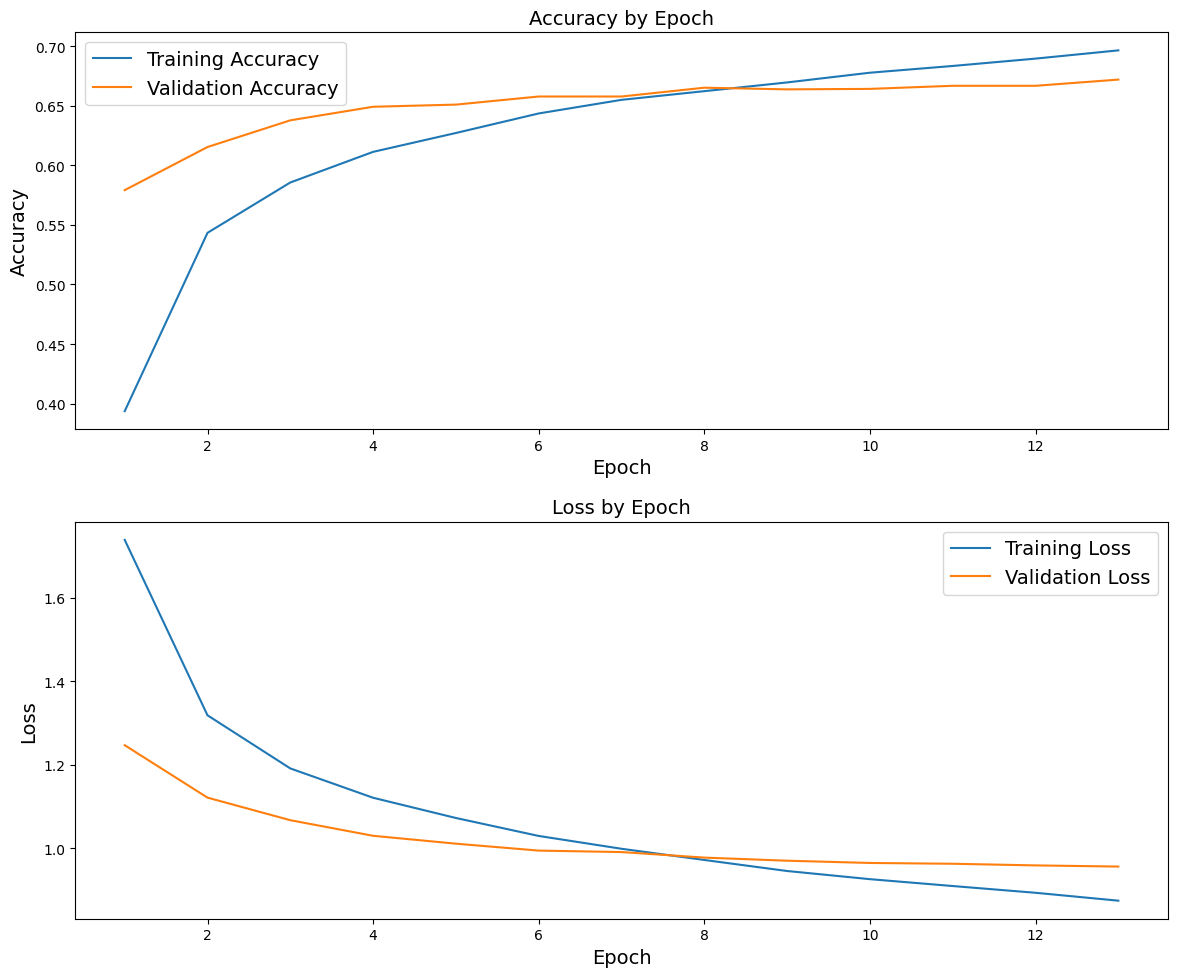

In [41]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_1_history_epochs, transfer_model_1_accuracy, label="Training Accuracy")
plt.plot(transfer_model_1_history_epochs, transfer_model_1_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_1_history_epochs, transfer_model_1_loss, label="Training Loss")
plt.plot(transfer_model_1_history_epochs, transfer_model_1_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
y_pred_probs = transfer_model_1.predict(X_test_scaled_64)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_1 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_1, y_pred)
prec = precision_score(y_test_transfer_model_1, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_1, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_1, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_1, y_pred, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
model_2 Accuracy: 0.6617
model_2 Precision: 0.6622
model_2 Recall: 0.6617
model_2 F1 Score: 0.6606

              precision    recall  f1-score   support

    airplane       0.64      0.71      0.67      1000
  automobile       0.76      0.78      0.77      1000
        bird       0.60      0.53      0.56      1000
         cat       0.53      0.52      0.52      1000
        deer       0.58      0.61      0.60      1000
         dog       0.65      0.57      0.61      1000
        frog       0.63      0.76      0.69      1000
       horse       0.72      0.67      0.69      1000
        ship       0.75      0.73      0.74      1000
       truck       0.76      0.75      0.75      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



# Transfer Learning Mobile Net v2  - Attempt 2  - no pre set weights

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [43]:
base_model_2 = MobileNetV2(
    input_shape=(64, 64, 3),    # lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "None",
    weights= None,
    )
base_model_2.trainable = True  # Don't freeze base so mobilenet v2 can be trained as we have no weights just the structure

In [44]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [45]:
transfer_model_2 = models.Sequential([
    base_model_2,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [46]:
transfer_model_2_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

transfer_model_2.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_2_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,                 # metric to monitor
    patience=3,                     # stop if no improvement after 3 epochs
    restore_best_weights=True
)

In [47]:
transfer_model_2_history = transfer_model_2.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.1897 - loss: 2.1596 - val_accuracy: 0.1020 - val_loss: 2.3061
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 38ms/step - accuracy: 0.3053 - loss: 1.8543 - val_accuracy: 0.1026 - val_loss: 2.3233
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 38ms/step - accuracy: 0.3865 - loss: 1.6763 - val_accuracy: 0.1100 - val_loss: 2.3725
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 38ms/step - accuracy: 0.4464 - loss: 1.5450 - val_accuracy: 0.1100 - val_loss: 2.3483


## Evaluating Model

In [48]:
transfer_model_2_accuracy = transfer_model_2_history.history["accuracy"]
transfer_model_2_accuracy_val = transfer_model_2_history.history["val_accuracy"]
transfer_model_2_loss = transfer_model_2_history.history["loss"]
transfer_model_2_loss_val = transfer_model_2_history.history["val_loss"]

transfer_model_2_history_epochs = range(1,len(transfer_model_2_accuracy)+1)

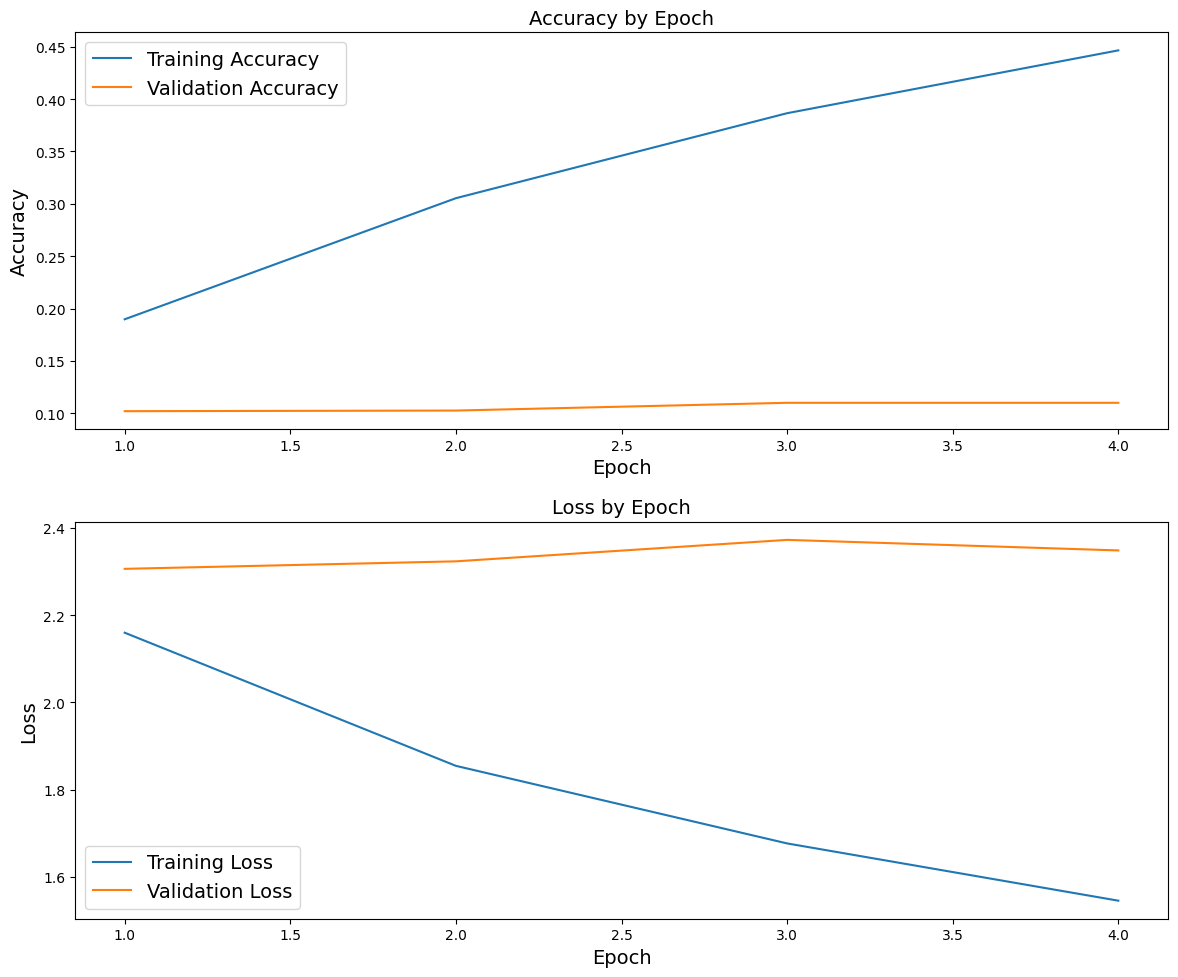

In [49]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_2_history_epochs, transfer_model_2_accuracy, label="Training Accuracy")
plt.plot(transfer_model_2_history_epochs, transfer_model_2_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_2_history_epochs, transfer_model_2_loss, label="Training Loss")
plt.plot(transfer_model_2_history_epochs, transfer_model_2_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [50]:
y_pred_probs = transfer_model_2.predict(X_test_scaled_64)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_2 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_2, y_pred)
prec = precision_score(y_test_transfer_model_2, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_2, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_2, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_2, y_pred, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
model_2 Accuracy: 0.1000
model_2 Precision: 0.0100
model_2 Recall: 0.1000
model_2 F1 Score: 0.0182

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.10      1.00      0.18      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/site-packag

# Transfer Learning Mobile Net v2  - Attempt 3  - much lower alpha - reduce filters per layer

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [51]:
base_model_3 = MobileNetV2(
    input_shape =(64, 64, 3),
    include_top =False,
    pooling = None,
    weights = None,
    alpha = 0.5
    )
base_model_3.trainable = True  # Don't freeze base so mobilenet v2 can be trained as we have no weights just the structure

In [52]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [53]:
transfer_model_3 = models.Sequential([
    base_model_3,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [54]:
transfer_model_3_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

transfer_model_3.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_3_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',             # metric to monitor
    min_delta=0.01,
    patience=3,                     # stop if no improvement after 3 epochs
    restore_best_weights=True
)

In [55]:
transfer_model_3_history = transfer_model_3.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - accuracy: 0.1365 - loss: 2.2679 - val_accuracy: 0.1020 - val_loss: 2.3053
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step - accuracy: 0.2194 - loss: 2.0714 - val_accuracy: 0.1020 - val_loss: 2.3474
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step - accuracy: 0.2827 - loss: 1.9131 - val_accuracy: 0.1020 - val_loss: 2.4684
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.3295 - loss: 1.8064 - val_accuracy: 0.1000 - val_loss: 2.5659


## Evaluating Model

In [56]:
transfer_model_3_accuracy = transfer_model_3_history.history["accuracy"]
transfer_model_3_accuracy_val = transfer_model_3_history.history["val_accuracy"]
transfer_model_3_loss = transfer_model_3_history.history["loss"]
transfer_model_3_loss_val = transfer_model_3_history.history["val_loss"]

transfer_model_3_history_epochs = range(1,len(transfer_model_3_accuracy)+1)

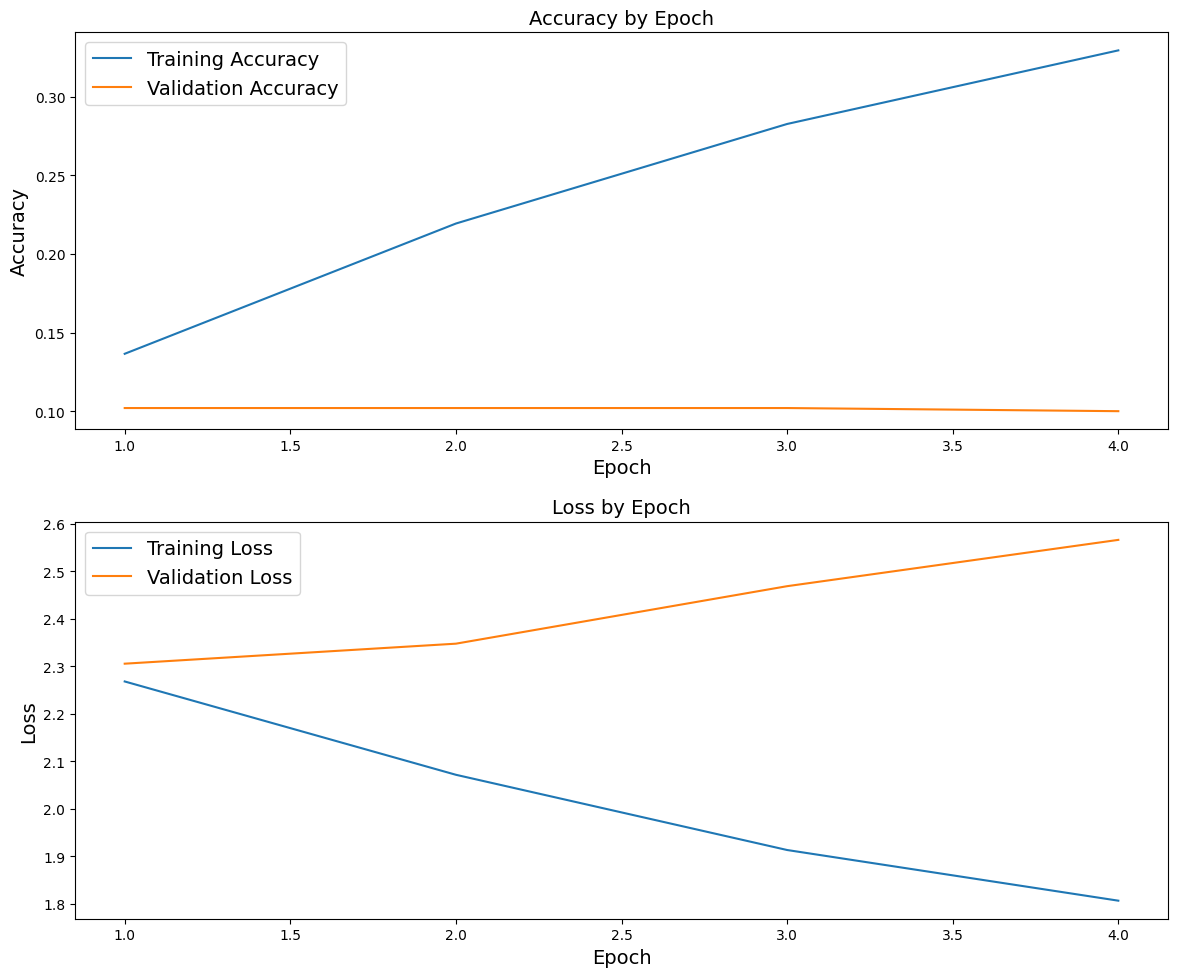

In [57]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_3_history_epochs, transfer_model_3_accuracy, label="Training Accuracy")
plt.plot(transfer_model_3_history_epochs, transfer_model_3_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_3_history_epochs, transfer_model_3_loss, label="Training Loss")
plt.plot(transfer_model_3_history_epochs, transfer_model_3_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [58]:
y_pred_probs = transfer_model_3.predict(X_test_scaled_64)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_3 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_3, y_pred)
prec = precision_score(y_test_transfer_model_3, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_3, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_3, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_3, y_pred, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
model_2 Accuracy: 0.1000
model_2 Precision: 0.0100
model_2 Recall: 0.1000
model_2 F1 Score: 0.0182

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.10      1.00      0.18      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/site-packag

# Transfer Learning EfiicientNetB0  - Attempt 1 

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [59]:
base_model_4 = EfficientNetB0(
    input_shape =(64, 64, 3),
    include_top =False,
    pooling = "None",
    weights = None
    )
base_model_4.trainable = True  # Don't freeze base so EfficientNetB0 can be trained as we have no weights just the structure

In [60]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [61]:
transfer_model_4 = models.Sequential([
    base_model_4,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [62]:
transfer_model_4_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

transfer_model_4.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_4_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',             # metric to monitor
    min_delta=0.01,
    patience=7,                     # stop if no improvement after 3 epochs
    restore_best_weights=True
)

In [63]:
transfer_model_4_history = transfer_model_4.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 127s 65ms/step - accuracy: 0.1456 - loss: 2.2652 - val_accuracy: 0.2020 - val_loss: 2.1940
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 70s 49ms/step - accuracy: 0.1899 - loss: 2.1619 - val_accuracy: 0.2188 - val_loss: 2.1000
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 70s 50ms/step - accuracy: 0.2178 - loss: 2.1030 - val_accuracy: 0.2528 - val_loss: 2.0251
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 72s 51ms/step - accuracy: 0.2341 - loss: 2.0664 - val_accuracy: 0.2692 - val_loss: 1.9915
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 72s 51ms/step - accuracy: 0.2419 - loss: 2.0371 - val_accuracy: 0.2772 - val_loss: 1.9911
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 72s 51ms/step - accuracy: 0.2586 - loss: 2.0132 - val_accuracy: 0.3014 - val_loss: 1.9324
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.2603 - loss: 2.0041 - val_accuracy: 0.2770 - val_loss: 2.0087
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy:

KeyboardInterrupt: 

## Evaluating Model

In [ ]:
transfer_model_4_accuracy = transfer_model_4_history.history["accuracy"]
transfer_model_4_accuracy_val = transfer_model_4_history.history["val_accuracy"]
transfer_model_4_loss = transfer_model_4_history.history["loss"]
transfer_model_4_loss_val = transfer_model_4_history.history["val_loss"]

transfer_model_4_history_epochs = range(1,len(transfer_model_4_accuracy)+1)

In [ ]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_4_history_epochs, transfer_model_4_accuracy, label="Training Accuracy")
plt.plot(transfer_model_4_history_epochs, transfer_model_4_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_4_history_epochs, transfer_model_4_loss, label="Training Loss")
plt.plot(transfer_model_4_history_epochs, transfer_model_4_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
y_pred_probs = transfer_model_4.predict(X_test_scaled_64)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_4 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_4, y_pred)
prec = precision_score(y_test_transfer_model_4, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_4, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_4, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_4, y_pred, target_names=class_names)
print(f"\n{report}")